In [2]:
pip install yfinance pandas matplotlib ta backtrader vectorbt numpy==2.2.0

Note: you may need to restart the kernel to use updated packages.


In [45]:
import backtrader as bt
import yfinance as yf
import pandas as pd
from datetime import time
import matplotlib.pyplot as plt

# 1) Data feed with VWAP
class PandasDataVWAP(bt.feeds.PandasData):
    lines = ('vwap',)
    params = dict(
        datetime=None, open='Open', high='High', low='Low',
        close='Close', volume='Volume', openinterest=None,
        vwap='VWAP'
    )

# 2) Strategy: ORB + VWAP + RSI, going all-in on each entry
class ORB_VWAP_RSI_AllIn(bt.Strategy):
    params = dict(rsi_period=14, rsi_thresh=50)

    def __init__(self):
        self.rsi      = bt.ind.RSI(self.data.close, period=self.p.rsi_period)
        self.today    = None
        self.OR_high  = 0.0
        self.OR_low   = float('inf')
        self.ordered  = False

    def notify_order(self, order):
        if order.status in (order.Submitted, order.Accepted):
            return
        dt = bt.num2date(order.executed.dt)
        if order.status == order.Completed:
            action = 'BUY' if order.isbuy() else 'SELL'
            print(f"{dt:%Y-%m-%d %H:%M} {action} {order.executed.size} @ ₹{order.executed.price:.2f}")
        else:
            print(f"{dt:%Y-%m-%d %H:%M} ORDER {'FILLED' if order.status==order.Completed else 'FAILED/CANCELED'}")

    def notify_trade(self, trade):
        if not trade.isclosed:
            return
        dt = bt.num2date(trade.dtclose)
        print(f"{dt:%Y-%m-%d %H:%M} TRADE CLOSED  GROSS: ₹{trade.pnl:.2f}  NET: ₹{trade.pnlcomm:.2f}")

    def next(self):
        dt = bt.num2date(self.data.datetime[0])
        d, t = dt.date(), dt.time()

        # New day: reset OR & flags
        if d != self.today:
            self.today   = d
            self.OR_high = self.data.open[0]
            self.OR_low  = self.data.open[0]
            self.ordered = False
            print(f"\n--- {d} ---")

        # Build Opening Range until 09:45
        if time(9,15) <= t <= time(9,45):
            self.OR_high = max(self.OR_high, self.data.high[0])
            self.OR_low  = min(self.OR_low,  self.data.low[0])

        # Log OR/VWAP/RSI at exactly 09:45
        if t == time(9,45):
            print(f"OR High: {self.OR_high:.2f}  OR Low: {self.OR_low:.2f}  "
                  f"VWAP: {self.data.vwap[0]:.2f}  RSI: {self.rsi[0]:.2f}")

        # After 09:45, if no position and not yet ordered, go all-in on a long if conditions met
        if t > time(9,45) and not self.position and not self.ordered:
            if (self.data.close[0] > self.OR_high
                and self.data.close[0] > self.data.vwap[0]
                and self.rsi[0] > self.p.rsi_thresh):
                cash = self.broker.getcash()
                size = int(cash / self.data.close[0])
                if size > 0:
                    self.buy(size=size)
                    self.ordered = True

        # Exit logic for an existing long:
        # exit if price < OR_low OR price < VWAP OR RSI < threshold OR time >= 15:15
        if self.position:
            exit_cond = (
                self.data.close[0] < self.OR_low or
                self.data.close[0] < self.data.vwap[0] or
                self.rsi[0] < self.p.rsi_thresh or
                t >= time(15,15)
            )
            if exit_cond:
                self.close()

if __name__ == '__main__':
    cerebro = bt.Cerebro()
    cerebro.addstrategy(ORB_VWAP_RSI_AllIn)

    # Download TCS 5-min bars for the last 60 days
    symbol = 'TCS.NS'
    df = yf.download(symbol, period='60d', interval='5m', progress=False).dropna()

    # Flatten MultiIndex if present, keep only OHLCV
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = df.columns.get_level_values(0)
    df = df[['Open','High','Low','Close','Volume']].copy()

    # Compute daily VWAP
    df['typical']    = (df['High'] + df['Low'] + df['Close']) / 3
    df['cum_vol_px'] = (df['typical'] * df['Volume']).groupby(df.index.date).cumsum()
    df['cum_vol']    = df.groupby(df.index.date)['Volume'].cumsum()
    df['VWAP']       = df['cum_vol_px'] / df['cum_vol']

    # Feed into Backtrader
    data = PandasDataVWAP(dataname=df)
    cerebro.adddata(data)

    # Starting capital & commission
    cerebro.broker.setcash(100_000)
    cerebro.broker.setcommission(commission=0.0002)

    print(f"\nSTARTING PORTFOLIO VALUE: ₹{cerebro.broker.getvalue():,.2f}")
    cerebro.run()
    print(f"ENDING   PORTFOLIO VALUE: ₹{cerebro.broker.getvalue():,.2f}")

    # Plot
    plt.rcParams['figure.figsize'] = [14, 8]
    cerebro.plot(style='candlestick')
    plt.show()


/var/folders/mn/tx231v5158797chnp22wm9000000gp/T/ipykernel_72346/685552067.py:94: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, period='60d', interval='5m', progress=False).dropna()



STARTING PORTFOLIO VALUE: ₹100,000.00

--- 2025-04-08 ---
OR High: 3305.00  OR Low: 3281.50  VWAP: 3295.22  RSI: 37.66

--- 2025-04-09 ---
OR High: 3253.75  OR Low: 3246.65  VWAP: 3250.04  RSI: 42.49

--- 2025-04-11 ---
OR High: 3284.05  OR Low: 3220.20  VWAP: 3242.67  RSI: 52.56

--- 2025-04-15 ---
OR High: 3295.30  OR Low: 3242.20  VWAP: 3255.22  RSI: 48.69

--- 2025-04-16 ---
OR High: 3276.00  OR Low: 3254.40  VWAP: 3260.73  RSI: 57.72

--- 2025-04-17 ---
OR High: 3303.40  OR Low: 3245.50  VWAP: 3264.58  RSI: 64.36

--- 2025-04-21 ---
OR High: 3331.00  OR Low: 3293.10  VWAP: 3327.27  RSI: 45.09

--- 2025-04-22 ---
OR High: 3321.00  OR Low: 3310.10  VWAP: 3315.10  RSI: 48.60

--- 2025-04-23 ---
OR High: 3420.30  OR Low: 3351.10  VWAP: 3400.40  RSI: 50.15

--- 2025-04-24 ---
OR High: 3406.10  OR Low: 3390.10  VWAP: 3398.77  RSI: 56.54
2025-04-24 09:55 BUY 29 @ ₹3407.30

--- 2025-04-25 ---
2025-04-25 04:00 SELL -29 @ ₹3455.90
2025-04-25 04:00 TRADE CLOSED  GROSS: ₹1409.40  NET: ₹1369.

<IPython.core.display.Javascript object>

Total Return     : -0.53 %
Annualized Sharpe: -0.10
Max Drawdown     : -1.92 %

————— Trade Metrics —————
Total Trades            : 1
Profitable Trades       : 0
Losing Trades           : 1
Win Rate                : 0.00 %
Average PnL per Trade   : ₹-534.07
Average Return per Trade: -0.53 %
Average Winning PnL     : ₹nan
Average Losing PnL      : ₹-534.07
Largest Win             : ₹-534.07
Largest Loss            : ₹-534.07



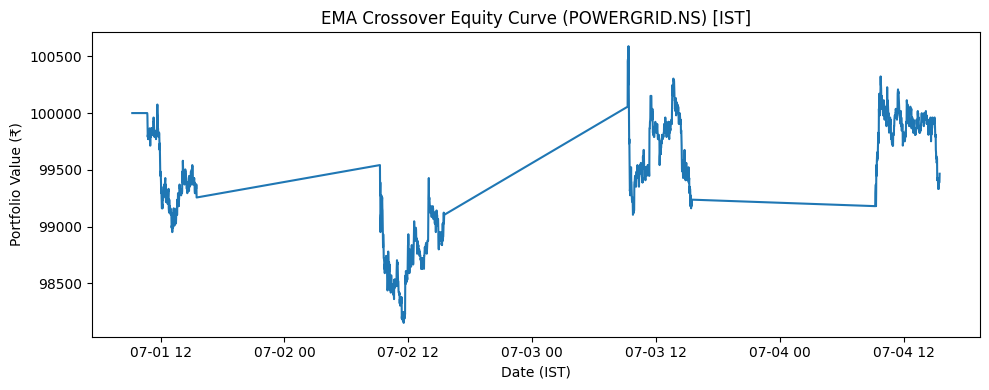

In [5]:
import vectorbt as vbt
import pandas as pd
import matplotlib.pyplot as plt

# 1. Download 5-min data for ETERNAL.NS
symbol = "ETERNAL.NS"
start  = "2025-07-01"
end    = "2025-07-07"

data  = vbt.YFData.download(symbol, start=start, end=end, interval="1m")
close = data.get('Close')

# 2. Compute EMAs
fast_ema = close.ewm(span=20, adjust=False).mean()
slow_ema = close.ewm(span=50, adjust=False).mean()

# 3. Build entry/exit signals
entries = fast_ema > slow_ema
exits   = None

# 4. Define a trailing stop of 0.1% (adjustable)
#    As price moves in your favor, the stop price moves up, always 0.1% below the peak since entry.
trail_pct = 100

# 4. Backtest with all-in sizing (₹100 000 per entry)
pf = vbt.Portfolio.from_signals(
    close,
    entries,
    exits,
    init_cash=100_000,
    size=100_000,
    size_type='value',   # interpret `size` as cash to invest
    fees=0.0001,
    slippage=0.0001,
    sl_trail=trail_pct
)

# 5. Print overall performance
print(f"Total Return     : {pf.total_return() * 100:.2f} %")
print(f"Annualized Sharpe: {pf.sharpe_ratio(freq='1D'):.2f}")
print(f"Max Drawdown     : {pf.max_drawdown() * 100:.2f} %\n")

# 6. Extract and convert trade timestamps to IST
trades_df = pf.trades.records_readable.copy()

# Directly convert from UTC → IST
trades_df['Entry Timestamp'] = trades_df['Entry Timestamp'].dt.tz_convert('Asia/Kolkata')
trades_df['Exit Timestamp']  = trades_df['Exit Timestamp'].dt.tz_convert('Asia/Kolkata')

trades_df.to_csv("powergrid_trades.csv", index=False)

# 7. Compute trade-level statistics
total_trades      = len(trades_df)
profitable_trades = (trades_df['PnL'] > 0).sum()
losing_trades     = total_trades - profitable_trades
win_rate          = profitable_trades / total_trades * 100 if total_trades else float('nan')
avg_pnl           = trades_df['PnL'].mean()
avg_return_pct    = trades_df['Return'].mean() * 100
avg_win           = trades_df.loc[trades_df['PnL'] > 0, 'PnL'].mean()
avg_loss          = trades_df.loc[trades_df['PnL'] <= 0, 'PnL'].mean()
max_win           = trades_df['PnL'].max()
max_loss          = trades_df['PnL'].min()

print("————— Trade Metrics —————")
print(f"Total Trades            : {total_trades}")
print(f"Profitable Trades       : {profitable_trades}")
print(f"Losing Trades           : {losing_trades}")
print(f"Win Rate                : {win_rate:.2f} %")
print(f"Average PnL per Trade   : ₹{avg_pnl:.2f}")
print(f"Average Return per Trade: {avg_return_pct:.2f} %")
print(f"Average Winning PnL     : ₹{avg_win:.2f}")
print(f"Average Losing PnL      : ₹{avg_loss:.2f}")
print(f"Largest Win             : ₹{max_win:.2f}")
print(f"Largest Loss            : ₹{max_loss:.2f}\n")

# 8. Plot equity curve in IST
eq_curve = pf.value().tz_convert('Asia/Kolkata')
plt.figure(figsize=(10, 4))
plt.plot(eq_curve.index, eq_curve.values)
plt.title("EMA Crossover Equity Curve (POWERGRID.NS) [IST]")
plt.xlabel("Date (IST)")
plt.ylabel("Portfolio Value (₹)")
plt.tight_layout()
plt.show()


Total Return     : -0.53 %
Annualized Sharpe: -0.10
Max Drawdown     : -1.92 %

   Exit Trade Id Column        Size           Entry Timestamp  \
0              0  Close  380.803686 2025-07-01 10:42:00+05:30   

   Avg Entry Price  Entry Fees            Exit Timestamp  Avg Exit Price  \
0       262.576243       9.999 2025-07-04 15:29:00+05:30      261.200012   

   Exit Fees         PnL    Return Direction Status  Position Id  
0        0.0 -534.072679 -0.005341      Long   Open            0   

————— Trade Metrics —————
Total Trades            : 1
Profitable Trades       : 0
Win Rate                : 0.00 %
Average PnL per Trade   : ₹-534.07
Average Return per Trade: -0.53 %
Largest Win             : ₹-534.07
Largest Loss            : ₹-534.07



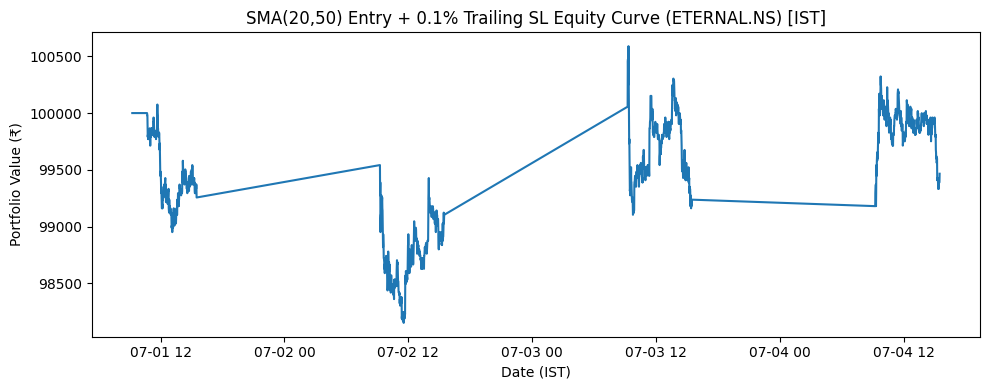

In [6]:
import vectorbt as vbt
import pandas as pd
import matplotlib.pyplot as plt

# 1. Download 1-min data for ETERNAL.NS
symbol = "ETERNAL.NS"
start  = "2025-07-01"
end    = "2025-07-07"

data  = vbt.YFData.download(symbol, start=start, end=end, interval="1m")
close = data.get('Close')

# 2. Compute SMAs for entry timing
sma_short = close.rolling(20).mean()
sma_long  = close.rolling(50).mean()

# 3. Build entry signals (short SMA crossing above long SMA)
entries = sma_short >= sma_long
# no fixed crossover‐based exit here
exits = None

# 4. Define a 0.1% trailing stop
#    (0.001 = 0.1% in decimal)
trail_pct = 0.001

# 5. Backtest with all-in sizing (₹100 000 per entry), 0.01% fees/slippage
pf = vbt.Portfolio.from_signals(
    close,
    entries,
    exits,
    init_cash=100_000,
    size=100_000,
    size_type='value',
    fees=0.0001,
    slippage=0.0001,
    sl_trail=trail_pct
)

# 6. Print overall performance
print(f"Total Return     : {pf.total_return() * 100:.2f} %")
print(f"Annualized Sharpe: {pf.sharpe_ratio(freq='1D'):.2f}")
print(f"Max Drawdown     : {pf.max_drawdown() * 100:.2f} %\n")

# 7. Extract and convert trade timestamps to IST
trades_df = pf.trades.records_readable.copy()
trades_df['Entry Timestamp'] = trades_df['Entry Timestamp'].dt.tz_convert('Asia/Kolkata')
trades_df['Exit Timestamp']  = trades_df['Exit Timestamp'].dt.tz_convert('Asia/Kolkata')
print(trades_df, "\n")

# 8. Compute trade-level stats
total_trades      = len(trades_df)
profitable_trades = (trades_df['PnL'] > 0).sum()
win_rate          = profitable_trades / total_trades * 100 if total_trades else float('nan')
avg_pnl           = trades_df['PnL'].mean()
avg_return_pct    = trades_df['Return'].mean() * 100
max_win           = trades_df['PnL'].max()
max_loss          = trades_df['PnL'].min()

print("————— Trade Metrics —————")
print(f"Total Trades            : {total_trades}")
print(f"Profitable Trades       : {profitable_trades}")
print(f"Win Rate                : {win_rate:.2f} %")
print(f"Average PnL per Trade   : ₹{avg_pnl:.2f}")
print(f"Average Return per Trade: {avg_return_pct:.2f} %")
print(f"Largest Win             : ₹{max_win:.2f}")
print(f"Largest Loss            : ₹{max_loss:.2f}\n")

# 9. Plot equity curve in IST
eq_curve = pf.value().tz_convert('Asia/Kolkata')
plt.figure(figsize=(10, 4))
plt.plot(eq_curve.index, eq_curve.values)
plt.title("SMA(20,50) Entry + 0.1% Trailing SL Equity Curve (ETERNAL.NS) [IST]")
plt.xlabel("Date (IST)")
plt.ylabel("Portfolio Value (₹)")
plt.tight_layout()
plt.show()


/var/folders/mn/tx231v5158797chnp22wm9000000gp/T/ipykernel_54728/3808795958.py:14: FutureWarning:

YF.download() has changed argument auto_adjust default to True



————— Trade Metrics —————
Total Trades            : 2
Profitable Trades       : 0
Win Rate                : 0.00 %
Average PnL per Trade   : ₹-73.48
Average Return per Trade: -0.07 %
Largest Win             : ₹-29.96
Largest Loss            : ₹-117.00

Final Portfolio Value   : ₹99,853.04


<Figure size 1000x500 with 0 Axes>

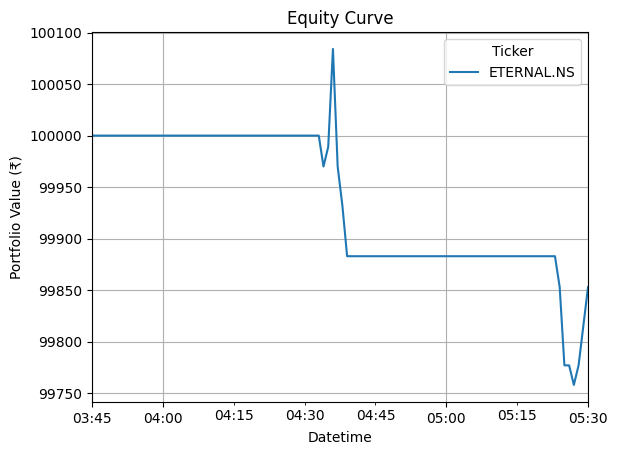

Trades exported to trades.csv (timestamps in IST)


In [21]:
import vectorbt as vbt
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import pytz

# Parameters
symbol     = 'ETERNAL.NS'
sma_short  = 20
sma_long   = 50
init_cash  = 100_000

# 1) Fetch the last 60 days of 5-minute bars
data = yf.download(symbol, period='1d', interval='1m', progress=False).dropna()
price = data['Close']

# 2) Compute SMAs (aligned by pandas rolling)
fast_ma = price.rolling(sma_short).mean()
slow_ma = price.rolling(sma_long).mean()

# 3) Signals: long when fast > slow, exit when fast < slow
entries = fast_ma > slow_ma
exits   = fast_ma < slow_ma

# 4) All-in sizing: invest full cash at each entry price
size = init_cash / price

# 5) Backtest with vectorbt
pf = vbt.Portfolio.from_signals(
    close=price,
    entries=entries,
    exits=exits,
    init_cash=init_cash,
    size=size,
    fees=0.0002,       # 0.02% commission per trade
    slippage=0.0001    # 0.01% slippage
)

# 6) Extract trades
trades = pf.trades.records_readable.copy()
if 'ReturnPct' not in trades.columns:
    trades['ReturnPct'] = trades['PnL'] / (abs(trades['Size'] * trades['Avg Entry Price'])) * 100

# 7) Compute metrics
total_trades      = len(trades)
profitable_trades = (trades['PnL'] > 0).sum()
win_rate          = profitable_trades / total_trades * 100 if total_trades else 0
avg_pnl           = trades['PnL'].mean() if total_trades else 0
avg_return_pct    = trades['ReturnPct'].mean() if total_trades else 0
max_win           = trades['PnL'].max() if total_trades else 0
max_loss          = trades['PnL'].min() if total_trades else 0

# 8) Print metrics and final capital
print("————— Trade Metrics —————")
print(f"Total Trades            : {total_trades}")
print(f"Profitable Trades       : {profitable_trades}")
print(f"Win Rate                : {win_rate:.2f} %")
print(f"Average PnL per Trade   : ₹{avg_pnl:.2f}")
print(f"Average Return per Trade: {avg_return_pct:.2f} %")
print(f"Largest Win             : ₹{max_win:.2f}")
print(f"Largest Loss            : ₹{max_loss:.2f}")
final_capital = pf.value().iloc[-1].item()
print(f"\nFinal Portfolio Value   : ₹{final_capital:,.2f}")

# 9) Plot equity curve
plt.figure(figsize=(10,5))
pf.value().plot(title="Equity Curve", ylabel="Portfolio Value (₹)")
plt.grid(True)
plt.show()

# 10) Export trades in IST to CSV
trades_ist = trades.copy()
for col in ['Entry Date', 'Exit Date']:
    if col in trades_ist.columns:
        trades_ist[col] = pd.to_datetime(trades_ist[col]) \
            .dt.tz_localize('UTC') \
            .dt.tz_convert('Asia/Kolkata')
trades_ist.to_csv('trades.csv', index=False)
print("Trades exported to trades.csv (timestamps in IST)")


In [22]:
import vectorbt as vbt
import pandas as pd

# 1. Download once
symbol = "POWERGRID.NS"
start, end = "2025-06-01", "2025-07-07"
data  = vbt.YFData.download(symbol, start=start, end=end, interval="5m")
close = data.get('Close')

# 2. Define grid of spans
fast_spans = [5, 8, 9, 12, 15]
slow_spans = [20, 21, 26, 30, 35, 50]

results = []
for fs in fast_spans:
    for ss in slow_spans:
        if fs >= ss:
            continue  # fast must be smaller than slow
        # 3. Compute EMAs
        fast_ema = close.ewm(span=fs, adjust=False).mean()
        slow_ema = close.ewm(span=ss, adjust=False).mean()
        # 4. Signals
        entries = fast_ema > slow_ema
        exits   = fast_ema < slow_ema
        # 5. Backtest
        pf = vbt.Portfolio.from_signals(
            close,
            entries,
            exits,
            init_cash=100_000,
            size=100_000,
            size_type='value',
            fees=0.0001,
            slippage=0.0001
        )
        # 6. Collect metrics
        results.append({
            'fast': fs,
            'slow': ss,
            'total_return_%': pf.total_return() * 100,
            'sharpe': pf.sharpe_ratio(freq='1D'),
            'max_dd_%': pf.max_drawdown() * 100,
            'win_rate_%': (pf.trades.records_readable['PnL'] > 0).mean() * 100
        })

# 7. Show top 5 by Sharpe
res_df = pd.DataFrame(results)
print(res_df.sort_values('sharpe', ascending=False).head(5))

# If you care more about raw returns, do:
print("\nTop 5 by Total Return:")
print(res_df.sort_values('total_return_%', ascending=False).head(5))


    fast  slow  total_return_%    sharpe  max_dd_%  win_rate_%
16     9    35        0.932186  0.108729 -3.347502   29.629630
11     8    50        0.756284  0.090285 -3.880093   29.629630
29    15    50        0.703961  0.083419 -3.580989   30.000000
27    15    30        0.654286  0.080109 -3.626285   29.166667
10     8    35        0.561602  0.069350 -3.356179   33.333333

Top 5 by Total Return:
    fast  slow  total_return_%    sharpe  max_dd_%  win_rate_%
16     9    35        0.932186  0.108729 -3.347502   29.629630
11     8    50        0.756284  0.090285 -3.880093   29.629630
29    15    50        0.703961  0.083419 -3.580989   30.000000
27    15    30        0.654286  0.080109 -3.626285   29.166667
10     8    35        0.561602  0.069350 -3.356179   33.333333
